# Case Study 4: Computational Methods in Finance

# Charles Laferte - cl4249

In [1]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs, minimize
from scipy.stats import norm

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Simulate the market data with Heston Stochastic Volatility Model

Let's set the parameters we will consider for the Heston model:

In [478]:
'''
kappa  = params[0];
theta  = params[1];
sigma  = params[2];
rho    = params[3];
v0     = params[4];
'''
S0 = 4100
r = 0.0485
mu = r
params = [0.02, 1.5, 0.05, 0.18, 0.5, 0.04]

In [479]:
N = 10*252 # 10 years * 252 trading day per year
T = 10

In [480]:
def heston_simulated_prices(params, N, T, S0, r, mu, plot = False):
    kappa  = params[0]
    theta  = params[1]
    sigma  = params[2]
    rho    = params[3]
    v0     = params[4]
    
    # Define discretization parameters
    dt = T/N        # time increment
    M = 1           # number of simulations

    # Generate random numbers
    Z1 = norm.rvs(size=(N, M))
    Z2 = rho*Z1 + np.sqrt(1-rho**2)*norm.rvs(size=(N, M))

    # Define arrays to store stock price and volatility paths
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))

    # Set initial values
    S[0,:] = S0
    v[0,:] = v0 #theta
    print(v0)
    
    # Calculate paths
    for i in range(N):
        v[i+1,:] = np.maximum(0, v[i,:] + kappa*(theta-v[i,:])*dt + sigma*np.sqrt(v[i,:])*np.sqrt(dt)*Z1[i,:])
        #print(v[i+1,:])
        S[i+1,:] = S[i,:] * np.exp((mu - 0.5*v[i,:])*dt + np.sqrt(v[i,:])*np.sqrt(dt)*Z2[i,:])
        #print(S[i+1,:])
    
    # Plot results
    if plot == True:
        plt.plot(S)
        plt.title('Simulated Heston Model Stock Price Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.show()
    
        plt.plot(v)
        plt.title('Simulated Heston Model volatility Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Volatility')
        plt.show()
        
    # Reshaping the outputs
    y = np.log(S)
    S = S.T
    S = S[0]
    v = v.T
    v = v[0]
    y = y.T
    y = y[0]
    
    return S, v, y
    

0.5


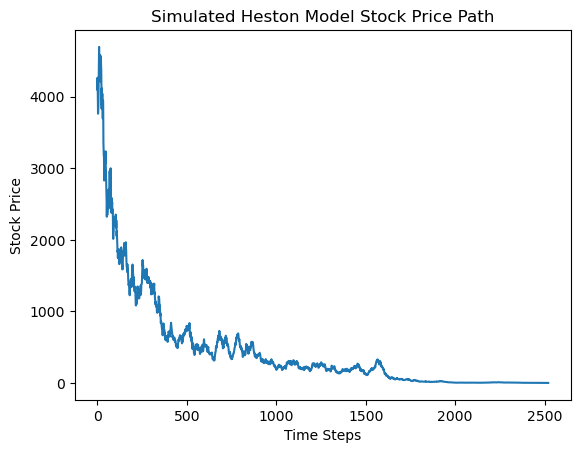

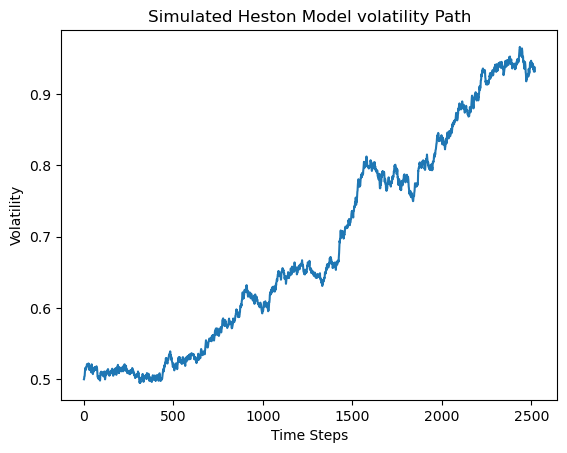

In [481]:
prices, v_, y = heston_simulated_prices(params, N, T, S0, r, mu, plot = True)

## 1. Extended Kalman Filter

In [452]:
def obj_function_ext_KF(params):
    mu     = params[0]
    kappa  = params[1]
    theta  = params[2]
    lbda   = params[3]
    rho    = params[4]
    v0     = params[5]

    dt = T/N        # time increment
    
    F = np.array([[1 , -0.5*dt], [0 , 1- kappa*dt]])   # state transition matrix
    Q = np.array([[1 , rho], [rho , 1]])
    P = np.diag(2*[0.01])
    
    log_lk = 0
    H = np.array([1, 0])
    
    v = v0
    
    for k in range(1,N):
        #v = v_[k-1]
        #S = prices[k]
        
        U  = np.diag([np.sqrt(v*dt), lbda*np.sqrt(v*dt)])
        
        #y[k-1] = np.lgS[k-1] # sortir de la loop ? 
        
        x_1 = np.array([y[k-1] + (mu - 0.5* v)*dt , v+ kappa*(theta-v)*dt])
        
        P_1 = F@P@F.T + U@Q@U.T 
        S = H@P_1@H.T #scalar
        K = P_1@H.T/S # scalar ie optimal Kalman gain 
        #print(K)
        v_1= x_1[1]
        
        e = (y[k]-y[k-1]) - (mu-0.5*v_1)*dt
        #print(e)
        log_lk = log_lk + np.log(S) + e**2/S
        
        x = x_1 + K*e
        
        v = x[1]

        P = (np.identity(np.shape(H)[0])- K@H) @ P_1
    
    return log_lk

In [453]:
def obj_function_ext_KF_2(params):
    mu     = params[0]
    kappa  = params[1]
    theta  = params[2]
    lbda   = params[3]
    rho    = params[4]
    v0     = params[5]

    dt = T/N        # time increment
    
    F = np.array([[1 , -0.5*dt], [0 , 1- kappa*dt]])   # state transition matrix
    Q = np.array([[1 , rho], [rho , 1]])
    P = np.diag(2*[0.01])
    I = np.identity(2)
    U = np.matrix([[np.sqrt(v0*dt), 0],[0, lbda*np.sqrt(v0*dt)]])
    
    H = np.array([1, 0])
    
    v = v0
    
    log_lk = 0
    
    for k in range(1,N):
        #v = v_[k-1]
        #S = prices[k]
        
        U  = np.diag([np.sqrt(v*dt), lbda*np.sqrt(v*dt)])
        
        #y[k-1] = np.lgS[k-1] # sortir de la loop ? 
        
        #x_1 = np.array([y[k-1] + (mu - 0.5* v)*dt , v + kappa*(theta-v)*dt])
        x_1 = np.array([y[k-1] + (mu - 0.5* v)*dt , v + kappa*(theta-v)*dt])
        
        P_1 = F@P@F.T + U@Q@U.T 
        S = H@P_1@H.T #scalar
        K = P_1@H.T/S # scalar ie optimal Kalman gain 
        #print(K)
        v_1= x_1[1]
        
        e = (y[k]-y[k-1]) - (mu-0.5*v_1)*dt
        #print(e)
        log_lk = log_lk + np.log(S) + e**2/S
        
        x = x_1 + K*e
        
        v = x[1]

        P = (np.identity(np.shape(H)[0])- K@H) @ P_1
    
    return log_lk

In [472]:
def ext_Kalman_filter(params):
    
    global y_KF, v_KF
    
    mu     = params[0]
    kappa  = params[1]
    theta  = params[2]
    lambda_= params[3]
    rho    = params[4]
    v_0    = params[5]
    
    dt = T/N 
        
    F = np.matrix([[1, -1/2*dt],[0, 1-kappa*dt]])
    U = np.matrix([[np.sqrt(v_0*dt), 0],[0, lambda_*np.sqrt(v_0*dt)]])
    Q = np.matrix([[1, rho],[rho, 1]])
    H = np.matrix([1,0])
    P = np.matrix([[0.01, 0],[0, 0.01]])
    I = np.identity(2)
    
    x_update = np.matrix([np.log(S0), v_0]).T
    
    y_KF = np.zeros(N)
    v_KF = np.zeros(N)
    
    func_obj = 0
    for i in range(1, N):
        
        x_pred = np.matrix([0,0], dtype=np.float64).T
        x_pred[0,0] = x_update[0,0] + (mu-1/2*x_update[1,0])*dt
        x_pred[1,0] = x_update[1,0] + kappa*(theta-x_update[1,0])*dt
        
        P_pred = F*P*F.T + U*Q*U.T
        
        A = H*P_pred*H.T
        
        A = A[0,0]
        
        err = y[i] - x_pred[0,0]
        
        func_obj += np.log(abs(A)) + err**2/A
        
        # Measurement 
        
        K = P_pred*H.T/A
        
        x_update = x_pred + K*err
        
        # check if volatility not negative
        x_update[1,0] = max(1e-7, x_update[1,0]) 
        
        vk = x_update[1,0]
        
        U = np.matrix([[np.sqrt(vk*dt), 0],[0, lambda_*np.sqrt(vk*dt)]])
        
        P = (I-K*H)*P_pred
        
        y_KF[i] = x_update[0,0]
        v_KF[i] = x_update[1,0]
        
    return func_obj/N
    

In [482]:
T/N 

0.003968253968253968

In [474]:
def obj_function_ext_KF_m(params):
    mu     = params[0]
    kappa  = params[1]
    theta  = params[2]
    lbda   = params[3]
    rho    = params[4]
    v0     = params[5]

    dt = T/N        # time increment
    #print(dt)
    #print('kappa*dt', kappa*dt)
    F = np.array([[1 , -0.5*dt], [0 , 1- kappa*dt]])   # state transition matrix
    #print('F', F)
    Q = np.array([[1 , rho], [rho , 1]])
    P = np.diag(2*[0.1])
    U = np.matrix([[np.sqrt(v0*dt), 0],[0, lbda*np.sqrt(v0*dt)]])
    
    log_lk = 0
    H = np.array([[1, 0]])
    
    v = v0
    
    x = np.array([[np.log(S0), v0]]) 
    
    for k in range(1,N):
        #v = v_[k-1]
        #S = prices[k]
        #print('iter ',k)
        #print('v', v)
        #U  = np.diag([np.sqrt(v*dt), lbda*np.sqrt(v*dt)])
        #print("U :", U)
        #y[k-1] = np.lgS[k-1] # sortir de la loop ?
        #print('xxxxxx',x)
        
        x_1 = np.array([x[0,0] + (mu - 0.5*v)*dt , v + kappa*(theta-v)*dt])
        #print('x_1 : ', x_1)
        #print('P',P)
        #print('F@P@F.T',F@P@F.T)
        #print('U@Q@U.T',U@Q@U.T )
        P_1 = F@P@F.T + U@Q@U.T 
        #print(P_1)
        S = H@P_1@H.T # scalar
        S = max(1e-3, S) 
        #print('S',S)
        #print('log(S)', np.log(S))
        K = P_1@H.T/S # scalar ie optimal Kalman gain 
        #print('K', K)
        v_1= x_1[1]
        
        e = (y[k]-y[k-1]) - (mu-0.5*v_1)*dt
        
        log_lk = log_lk + np.log(S) + e**2/S
        #print(log_lk)
        #print('e ', e)
        x = x_1 + K.T*e
        #print('x',x)
        
        '''if np.isnan(x[0,1]) or x[0,1]<0 : 
            v = 0
            #print('vv', v)
        else:'''
        x[0,1] = max(1e-7, x[0,1]) 
        #print('x apres max',x)
        v = x[0,1]#np.max(x[0,1],1e-6)
            #print('vvvv',v)
        
        '''print('test')
        print(type(K))
        print(K)
        print(H)
        print('K@H',K@H)
        print(np.identity(np.shape(H)[0]))'''
        ## je sais pas d'ou vient la lgne suivante
        U = np.matrix([[np.sqrt(v*dt), 0],[0, lbda*np.sqrt(v*dt)]])
        
        P = (np.identity(np.shape(H)[0]) - K@H) @ P_1 # updating P
        #print('P',P)
        ## je sais pas d'ou vient la lgne suivante
        
    
        #print('log_lk', log_lk)
    return log_lk

Set the initial guess for the optimization : 

In [483]:
params_0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05]
#params_0 = [0.02, 1.5, 0.05, 0.18, 0.5, 0.1]
params_0 = [0.03, 1.3, 0.07, 0.3, 0.6, 0.06]

Use the Nelder-Mead algorithm to minimize the function

In [470]:
def opt_param_research():
    
    def callback(x):
        print("Current parameter vector:", x)

    
    #constraint1 = {'type': 'ineq', 'fun': lambda x: x}#[0] - 1}
    #constraint2 = {'type': 'ineq', 'fun': lambda x: 2 - x[0]}
    #constraints = [constraint1]#, constraint2]
    #bounds = [(0.000001, 2)]*6
    #bounds[1] = (0,2)
    #bounds[4] = (-1,1)
    #result = minimize(ext_Kalman_filter, params_0, bounds=bounds, callback=callback)
    #result_2 = minimize(obj_function_ext_KF_m, params_0, bounds=bounds, callback=callback)# method='Nelder-Mead',
    xopt, fopt, _, _, _ = fmin(ext_Kalman_filter, params_0, maxiter=100, callback=callback, disp=True, retall=False, full_output=True)

    #result = fmin(ext_Kalman_filter, params_0, callback=callback)
    print(80*'=')
    print('Optimal parameter set:')
    print(opt)
    print(80*'=')
    
    return xopt

In [471]:
result_EKF = opt_param_research()

Current parameter vector: [0.03075 1.3325  0.07175 0.3075  0.54    0.0615 ]
Current parameter vector: [0.03075 1.3325  0.07175 0.3075  0.54    0.0615 ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Current parameter vector: [0.031      1.34333333 0.07233333 0.31       0.57333333 0.058     ]
Cu

KeyboardInterrupt: 

In [477]:
print(len(y))

2521


ValueError: x and y must have same first dimension, but have shapes (500,) and (2520,)

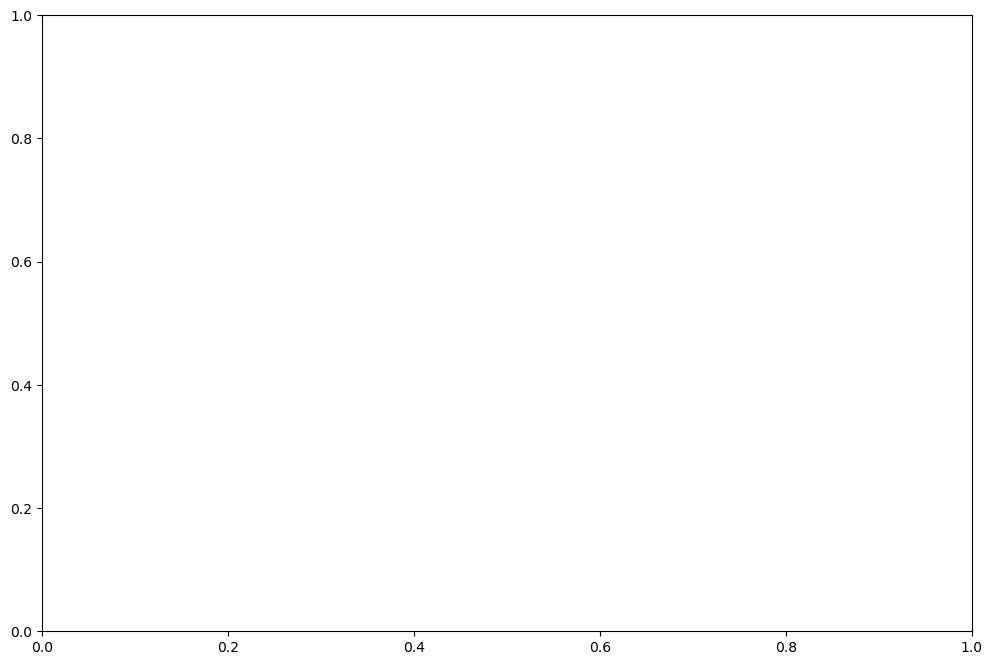

In [476]:
plt.figure(figsize=(12,8))
years = np.arange(obs.shape[-1]) * (T/N)
plt.plot(years, y[1:], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years[1:], y_KF[1:], label = 'Particle Filter log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.show()

In [ ]:
result_EKF

In [34]:
result_EKF

array([0.03055045, 1.31445619, 0.07227819, 0.29625844, 0.61083755,
       0.05886996])

In [21]:
params

[0.02, 1.5, 0.05, 0.18, 0.5, 0.04]

## 2. Particle Filtering

In [6]:
def n_function(x,m,s):
    n = -(x-m)**2/(2*s**2)
    return(np.exp(n)/(np.sqrt(2*np.pi)*s))

In [7]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

def heston_log_likelihood(params, y):
    # Extract parameters
    kappa, theta, sigma, rho, v0 = params

    # Initialize particles randomly
    N = 1000
    mu = np.random.normal(0, 1, size=N)
    v = np.random.gamma(shape=v0, scale=1/v0, size=N)
    w = np.ones(N) / N

    # Loop over time steps
    log_likelihood = 0
    for t in range(1, len(y)):
        # Resample particles according to weights
        # Remove NaN values from the weights and replace them with zeros
        w[np.isnan(w)] = 0
        mag = np.sum(w)
        print(mag)
        w = w/mag
        print(np.sum(w))
        #w = np.nan_to_num(w)
        print(w)
        idx = np.random.choice(N, size=N, replace=True, p=w)
        mu = mu[idx]
        v = v[idx]

        # Compute log-likelihood of observations given particles
        log_likelihood += np.log(w.dot(stats.norm.pdf(y[t], loc=mu*np.sqrt(v), scale=np.sqrt(v))))
        
        # Update particles
        mu += kappa * (theta - v) + np.sqrt(v) * np.random.normal(0, 1, size=N)
        v += sigma * np.sqrt(v) * np.random.normal(0, 1, size=N) + rho * np.sqrt(v) * np.random.normal(0, 1, size=N)
        
        # Resample if effective sample size is low
        if 1 / np.sum(w**2) < N / 2:
            mu = np.random.choice(mu, size=N, replace=True)
            v = np.random.choice(v, size=N, replace=True)
            w = np.ones(N) / N
            print('if', w)
        else:
            print('else')
            print(w)
            print(v)
            print(y[t])
            w = w * stats.norm.pdf(y[t], loc=mu*np.sqrt(v), scale=np.sqrt(v))
            w /= np.sum(w)
            print('else:',w)

    return -log_likelihood



In [8]:
'''# Generate some synthetic data from the Heston model
np.random.seed(123)
params_true = [1.5, 0.04, 0.3, -0.5, 0.04]
y = [100]
for t in range(1, 250):
    y_t = y[t-1] + np.random.normal(0, 1) * np.sqrt(np.exp(np.random.normal(params_true[1], params_true[2]**2)))
    y.append(y_t)

# Fit the Heston model using particle filtering
result = minimize(heston_log_likelihood, x0=[1, 0.02, 0.2, -0.1, 0.01], args=(y,), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None), (-1, 1), (0, None)])
print('Estimated parameters:', result.x)'''


"# Generate some synthetic data from the Heston model\nnp.random.seed(123)\nparams_true = [1.5, 0.04, 0.3, -0.5, 0.04]\ny = [100]\nfor t in range(1, 250):\n    y_t = y[t-1] + np.random.normal(0, 1) * np.sqrt(np.exp(np.random.normal(params_true[1], params_true[2]**2)))\n    y.append(y_t)\n\n# Fit the Heston model using particle filtering\nresult = minimize(heston_log_likelihood, x0=[1, 0.02, 0.2, -0.1, 0.01], args=(y,), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None), (-1, 1), (0, None)])\nprint('Estimated parameters:', result.x)"

In [9]:
# Fit the Heston model using particle filtering
result = minimize(heston_log_likelihood, x0=[1, 0.02, 0.2, -0.1, 0.01], args=(y,), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None), (-1, 1), (0, None)])
print('Estimated parameters:', result.x)

1.0000000000000004
0.9999999999999993
[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 

ValueError: probabilities contain NaN

### Version 2:


In [10]:
def proposal_distribution(N, x_prev, dy, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    return norm.rvs(m, s, N)

In [11]:
def likelihood(y, x, x_prev, y_prev, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x_prev*dt)
    
    return norm.pdf(y,m,s)

In [12]:
def transition(x, x_prev, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
        s = 1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt)
        
        return norm.pdf(x, m, s)

In [13]:
def proposal(x, x_prev, dy, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
        s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
        
        return norm.pdf(x, m, s)

In [14]:
def parameter_states_init(N, bounds):
    # initialize param states
    params_states = np.zeros((len(bounds)
        , N))
    b0, b1, b2, b3, b4 = bounds
    params_states[0] = np.random.rand(N)*(b0[1]-b0[0])+b0[0]
    params_states[1] = np.random.rand(N)*(b1[1]-b1[0])+b1[0]
    params_states[2] = np.random.rand(N)*(b2[1]-b2[0])+b2[0]
    params_states[3] = np.random.rand(N)*(b3[1]-b3[0])+b3[0]
    params_states[4] = np.random.rand(N)*(b4[1]-b4[0])+b4[0]
    return params_states

In [346]:
def resample_state(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. 
    indexes = np.searchsorted(cumulative_sum, np.random.rand(N))
    print('mean 1 part', np.mean(particles))
    particles[:] = particles[indexes]
    new_weights = np.ones(len(weights)) / len(weights)
    print('mean 2 part', np.mean(particles))
    return particles, new_weights

In [347]:
def resample(x_pred, weights, params_states):
        params_states[0], _ = resample_state(params_states[0], weights)
        params_states[1], _ = resample_state(params_states[1], weights)
        params_states[2], _ = resample_state(params_states[2], weights)
        params_states[3], _ = resample_state(params_states[3], weights)
        params_states[4], _ = resample_state(params_states[4], weights)
        x_pred, weights = resample_state(x_pred, weights)
        return x_pred, weights, params_states

In [348]:
def prediction_density(y, y_prev, x, mu):
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x*dt)
    return norm.pdf(y, m, s)

def prediction_density_v(v, x_prev, dy, lambda_,rho, theta, kappa):#(v, v_prev, x, mu, params):
    #mu, kappa, theta, lambda_, rho = params
    #m = v_prev + (mu-1/2*x)*dt
    #s = np.sqrt(x*dt)
    #return norm.pdf(y, m, s) # cf equation 8.43
    #proposal
    #m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    #s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    '''print('k', kappa)
    print('t', theta)
    print('x',x_prev)'''
    #transition
    m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
    #print('m',m)
    s = (1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt))
        
        
    # last trial=
    #delta = kappa*theta- rho*lambda_*mu-(kappa-0.5*rho*lambda_)*x_prev
    #m = x_prev+delta*dt+rho*y_prev
    return norm.pdf(v, m, s)

In [349]:
def predict(x_pred, particles, y_prev, mu):
    
    y_hat = y_prev + (mu-1/2*x_pred)*dt + np.sqrt(particles*dt)*norm.rvs()
    #print('yhat', y_hat)
    py_hat = np.array([np.mean(prediction_density(y_hat[k], y_prev, x_pred, mu)) for k in range(len(y_hat))])
    
    py_hat = py_hat/sum(py_hat)
    
    return np.sum(py_hat * y_hat)

In [427]:
def predict_v(x_pred, particles, v_prev, mu, lambda_,rho, theta, kappa, weights, params, dy):
    #print('mu', mu)
    #print('lbda', lambda_)
    #print('particles', particles)
    #print('rho',rho)
    #mu, kappa, theta, lambda_, rho = params
    #print('rho_2', rho)
    #v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*x_pred)*dt)-(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    #v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*particles)*dt)-(mu-1/2*v_prev)*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    # best so far v_hat = v_prev + (theta-1/2*x_pred)*dt - lambda_*rho*(((mu-1/2*x_pred)*dt)-(mu-1/2*v_prev)*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*particles)*dt)-(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    
    
    #v_hat = v_prev + kappa*(theta-particles)*dt #+ lambda_*rho*(dy -(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs()# + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    #v_hat = x_pred
    #v_hat = x_pred
    #print('ICI',lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs())
    
    #v_hat = 1/(1+1/2*lambda_*rho*dt) * (v_prev + kappa*(theta-v_prev)*dt + 1/2*lambda_*rho*v_prev*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    #v_hat = v_prev + kappa*(theta-v_prev)*dt
    #print('vhat', v_hat)
    # il manque peut etre un kappa juste au dessus
    '''print('vhat', np.shape(v_hat))
    print(np.mean(v_hat))
    print('vprev', np.shape(v_prev))
    print(v_prev)
    '''
    #pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], x_pred, dy, params)) for k in range(len(v_hat))])
    #pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], v_prev, dy, params)) for k in range(len(v_hat))])
    pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], particles[k], dy,lambda_,rho, theta,kappa)) for k in range(len(v_hat))])
    #print('pvhat', pv_hat)
    pv_hat = pv_hat/sum(pv_hat)
    #print('pvhat', pv_hat)
    #print('prod',(pv_hat * v_hat))
    print('return', np.sum(pv_hat * v_hat))
    return np.sum(pv_hat * v_hat)
    #return(np.sum(v_hat*weights))

In [428]:
def _neff(weights):
        return 1. / np.sum(np.square(weights))

In [435]:
def particle_filter(params):
    global y_PF, v_PF, v_PF_bis
    
    mu, kappa, theta, lambda_, rho, v_0 = params
    
    print(params[:-1])
    
    params_states = parameter_states_init(N, params[:-1])
    
    y_PF = np.zeros(N)
    v_PF = np.zeros(N)
    v_PF_bis = np.zeros(N)
    
    y_PF[0] = y[0]
    v_PF[0] = v_0
    v_PF_bis[0] = v_0
    
    weights = np.array([1/N] * N)
    print(v_0)
    particles = norm.rvs(v_0, 0.02, N) # hyper important 0.002 avant 0.02
    particles = np.maximum(1e-4, particles)
    
    params_steps = np.zeros((len(params)-1, len(y)))
    params_steps.transpose()[0] = np.mean(params_states, axis=1)
    
    for i in range(1, N):
        dy = y[i] - y[i-1]
        
        x_pred = proposal_distribution(N, particles, dy, params_states)
        x_pred = np.maximum(1e-3, x_pred)
        #print('first xpred', x_pred)
        
        Li = likelihood(y[i], x_pred, particles, y[i-1], params_states)
        I = proposal(x_pred, particles, dy, params_states)
        T = transition(x_pred, particles, params_states)
        weights = weights * (Li*T/I)
        weights = weights/sum(weights)
        print('mean 0 part', np.mean(particles))
        print('_neff', _neff(weights))
        if _neff(weights) < 0.6*N: # 0.7 avant 
            print('resampling since: {}'.format(_neff(weights)))
            x_pred, weights, params_states = resample(x_pred, weights, params_states)
        #print('second xpred', x_pred)
        y_hat = predict(x_pred, particles, y[i-1], np.mean(params_states[0]))
        y_PF[i] = y_hat
        
        #v_PF_bis[i] = np.sum(x_pred * weights)
        v_PF_bis[i] = np.sum((particles + np.mean(params_states[1])*(np.mean(params_states[2])-particles)*dt)* weights)
        print('v_PF_bis', v_PF_bis[i])
        print('np.sum w* xpred', np.sum(x_pred * weights))
        print('mean xpred', np.mean(x_pred))
        print('real x', v_[i])
        #v_PF[i] = predict_v(x_pred, particles, x_pred, np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
       
        #v_PF[i] = predict_v(x_pred, particles, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
        #v_PF[i] = predict_v(x_pred * weights, particles* weights, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
        v_PF[i] = predict_v(x_pred, particles, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),np.mean(params_states[1]),weights, params_states, dy)# np.sum(x_pred * weights)
        #v_PF[i] = np.mean(x_pred)
        #v_PF[i] = np.mean(x_pred)
        particles = x_pred
        params_steps.transpose()[i] = np.sum(np.multiply(params_states, weights[np.newaxis, :]), axis=1)
        
        print("Done with iter: {}".format(i))
    print(np.sum(np.multiply(params_states, weights[np.newaxis, :]), axis=1))
    return (v_PF,v_PF_bis, params_steps, y_PF)

In [436]:
print(params)

[0.02, 1.5, 0.05, 0.18, 0.5, 0.04]


0.5


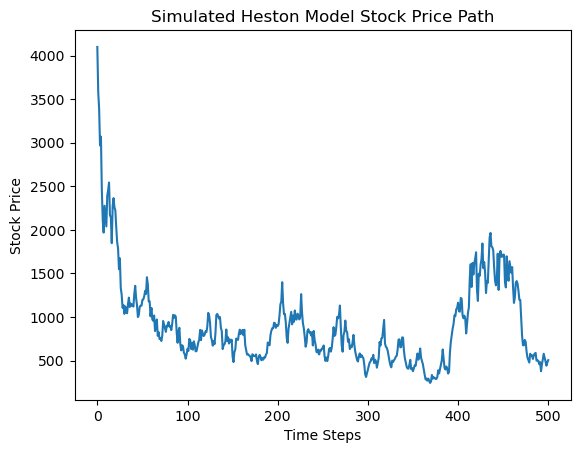

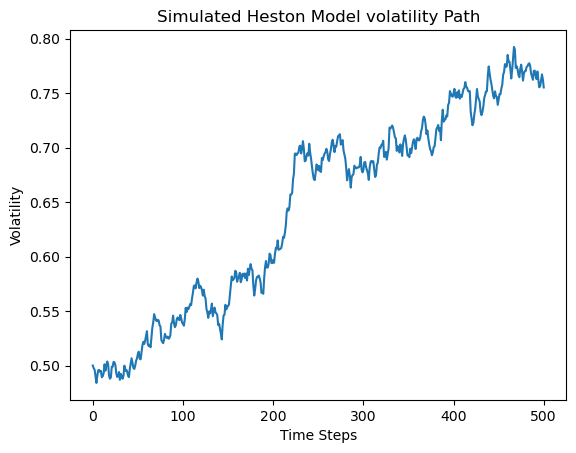

0.5


In [437]:
S0 = 4100
r = 0.0485
mu = r
params = [0.02, 1.5, 0.05, 0.18, 0.5, 0.04]
N = 500
T = 10
dt = T/N
prices, v_, y = heston_simulated_prices(params, N, T, S0, r, mu, plot = True)

mu = (0.01, 0.05)
kappa = (1, 9)
theta = (0.02, 0.2)
lambda_ = (0.01, 0.5)#91)
rho = (-0.5, 1)
v_0 = params[-2]
print(v_0)

params_0 = [mu, kappa, theta, lambda_, rho, v_0]

In [438]:
params_0

[(0.01, 0.05), (1, 9), (0.02, 0.2), (0.01, 0.5), (-0.5, 1), 0.5]

In [439]:
v, v_bis, param_steps, obs = particle_filter(params_0)

[(0.01, 0.05), (1, 9), (0.02, 0.2), (0.01, 0.5), (-0.5, 1)]
0.5
mean 0 part 0.49944268599314035
_neff 108.52964963335873
resampling since: 108.52964963335873
mean 1 part 0.030418035576365462
mean 2 part 0.0306083806753967
mean 1 part 5.037924523762398
mean 2 part 5.165049703596906
mean 1 part 0.10696182478419335
mean 2 part 0.10900182909595509
mean 1 part 0.24378872778130126
mean 2 part 0.23499507929413346
mean 1 part 0.25662948274974917
mean 2 part 0.2058228060373767
mean 1 part 0.4518237738749084
mean 2 part 0.4549403538914812
v_PF_bis 0.45910975734936177
np.sum w* xpred 0.45494035389148124
mean xpred 0.4549403538914812
real x 0.49744486009935424
return 0.5247253441428705
Done with iter: 1
mean 0 part 0.4549403538914812
_neff 395.941352834755
v_PF_bis 0.4184520444095653
np.sum w* xpred 0.41841166089704895
mean xpred 0.41761161345945164
real x 0.4960592972055527
return 0.51448580805713
Done with iter: 2
mean 0 part 0.41761161345945164
_neff 56.38605807743155
resampling since: 56.38605

v_PF_bis 0.2711856756015056
np.sum w* xpred 0.26280262015539024
mean xpred 0.26280262015539024
real x 0.48786966064447945
return 0.5876492913253643
Done with iter: 19
mean 0 part 0.26280262015539024
_neff 463.5638196222477
v_PF_bis 0.2443030171307016
np.sum w* xpred 0.24549395526061762
mean xpred 0.2491990871129046
real x 0.4891614707451819
return 0.6245905031893614
Done with iter: 20
mean 0 part 0.2491990871129046
_neff 174.76869103288075
resampling since: 174.76869103288075
mean 1 part 0.029617515566307824
mean 2 part 0.029415471730037442
mean 1 part 4.455703575668347
mean 2 part 4.377750950559454
mean 1 part 0.11166502711684262
mean 2 part 0.11413577472234811
mean 1 part 0.2544541232980493
mean 2 part 0.2549884574428204
mean 1 part 0.2526780248258457
mean 2 part 0.261563847971815
mean 1 part 0.23008200315463317
mean 2 part 0.23834798424914025
v_PF_bis 0.23737361622883518
np.sum w* xpred 0.23834798424914025
mean xpred 0.23834798424914025
real x 0.4987950970381411
return 0.63450134200

mean 0 part 0.16300997183882526
_neff 447.0671858703815
v_PF_bis 0.15461234127756499
np.sum w* xpred 0.1535573106197614
mean xpred 0.15678120191557984
real x 0.4947464610987937
return 0.6198388069781703
Done with iter: 38
mean 0 part 0.15678120191557984
_neff 425.4433089659037
v_PF_bis 0.14545994558865286
np.sum w* xpred 0.1454904023116741
mean xpred 0.15354422324814138
real x 0.4908630392718511
return 0.6277501014703873
Done with iter: 39
mean 0 part 0.15354422324814138
_neff 386.9875166960666
v_PF_bis 0.13813132393988722
np.sum w* xpred 0.13724633345445436
mean xpred 0.14904612478123136
real x 0.48935281567532785
return 0.6070953386717867
Done with iter: 40
mean 0 part 0.14904612478123136
_neff 109.62059263244186
resampling since: 109.62059263244186
mean 1 part 0.031042714163865573
mean 2 part 0.031634471388782434
mean 1 part 4.659608684243292
mean 2 part 4.480330636587103
mean 1 part 0.1146153811906328
mean 2 part 0.13006596994772224
mean 1 part 0.21858423800756493
mean 2 part 0.216

mean 0 part 0.17760146402701094
_neff 375.0299503567933
v_PF_bis 0.17794478843949757
np.sum w* xpred 0.1782640849330538
mean xpred 0.17449916556145373
real x 0.531512256006589
return 0.6887939650225764
Done with iter: 60
mean 0 part 0.17449916556145373
_neff 195.76271233240487
resampling since: 195.76271233240487
mean 1 part 0.03456042423256755
mean 2 part 0.03443898112547221
mean 1 part 4.789259630995957
mean 2 part 4.813761721108137
mean 1 part 0.13812900579436432
mean 2 part 0.14096036912631302
mean 1 part 0.21626214436160854
mean 2 part 0.21415338880136991
mean 1 part 0.019657433555883414
mean 2 part 0.042764698551764575
mean 1 part 0.17039382204819828
mean 2 part 0.17970605396135553
v_PF_bis 0.17127021007242338
np.sum w* xpred 0.17970605396135556
mean xpred 0.17970605396135553
real x 0.5194555678614513
return 0.7069036657478731
Done with iter: 61
mean 0 part 0.17970605396135553
_neff 477.4054072722872
v_PF_bis 0.1737900736846703
np.sum w* xpred 0.17518520577931723
mean xpred 0.176

mean 0 part 0.18533801635699163
_neff 235.4536062374551
resampling since: 235.4536062374551
mean 1 part 0.035144986347775006
mean 2 part 0.03600973548089392
mean 1 part 4.235174276342322
mean 2 part 4.185807461518183
mean 1 part 0.16476095880193511
mean 2 part 0.16803949214882968
mean 1 part 0.268768349606828
mean 2 part 0.2736243701851621
mean 1 part -0.0736846171733519
mean 2 part -0.08063117400087537
mean 1 part 0.18210295089696366
mean 2 part 0.19582636971341763
v_PF_bis 0.1838898505229161
np.sum w* xpred 0.19582636971341763
mean xpred 0.19582636971341763
real x 0.524583662467702
return 0.9441997372896888
Done with iter: 84
mean 0 part 0.19582636971341763
_neff 472.58595866192525
v_PF_bis 0.1907038757870831
np.sum w* xpred 0.19006005302691656
mean xpred 0.19372410818853203
real x 0.5253908741451335
return 0.9510944002033068
Done with iter: 85
mean 0 part 0.19372410818853203
_neff 448.55466280370206
v_PF_bis 0.18465614783619
np.sum w* xpred 0.18443643291258452
mean xpred 0.191135201

mean 0 part 0.29753099765388213
_neff 487.0754747907582
v_PF_bis 0.2859413773890287
np.sum w* xpred 0.28563890114189405
mean xpred 0.2859230429880422
real x 0.5565037034468314
return 1.0309270305557416
Done with iter: 108
mean 0 part 0.2859230429880422
_neff 449.2903652629942
v_PF_bis 0.2872528797163484
np.sum w* xpred 0.28682632065081404
mean xpred 0.272920509009569
real x 0.5553913789528943
return 0.9954333218129932
Done with iter: 109
mean 0 part 0.272920509009569
_neff 462.7013689135004
v_PF_bis 0.2716051015566921
np.sum w* xpred 0.2735574588363862
mean xpred 0.26730925734025507
real x 0.5616710932162404
return 1.0026183205715533
Done with iter: 110
mean 0 part 0.26730925734025507
_neff 443.63726193738836
v_PF_bis 0.2688747887093566
np.sum w* xpred 0.2703459698671836
mean xpred 0.2648494059121057
real x 0.5666558532685259
return 0.9958009543313309
Done with iter: 111
mean 0 part 0.2648494059121057
_neff 429.02687838418433
v_PF_bis 0.26259808684219793
np.sum w* xpred 0.2622390421659

Done with iter: 135
mean 0 part 0.31508462083771555
_neff 399.4277637971096
v_PF_bis 0.27819833879321165
np.sum w* xpred 0.27757496894937667
mean xpred 0.3085295165815038
real x 0.548953091987931
return 0.7963804164034465
Done with iter: 136
mean 0 part 0.3085295165815038
_neff 429.83738558546514
v_PF_bis 0.29562859247664236
np.sum w* xpred 0.29646467901971496
mean xpred 0.2959157266328416
real x 0.5478400074316446
return 0.7975818847233599
Done with iter: 137
mean 0 part 0.2959157266328416
_neff 420.20116997362015
v_PF_bis 0.2838433059320571
np.sum w* xpred 0.28139219209260125
mean xpred 0.2843571441780216
real x 0.5462497996706184
return 0.7692564985236126
Done with iter: 138
mean 0 part 0.2843571441780216
_neff 127.49021343827701
resampling since: 127.49021343827701
mean 1 part 0.03070171608732755
mean 2 part 0.031106318918166224
mean 1 part 2.908585976027622
mean 2 part 2.437555159797373
mean 1 part 0.1755072134344881
mean 2 part 0.17888183667275065
mean 1 part 0.2854963435178568
m

Done with iter: 163
mean 0 part 0.3483053641895591
_neff 247.53481723074398
resampling since: 247.53481723074398
mean 1 part 0.030933976206788956
mean 2 part 0.031240547526718312
mean 1 part 1.9571958093210078
mean 2 part 1.8937214325732088
mean 1 part 0.17662686184766552
mean 2 part 0.1760479334167759
mean 1 part 0.307505841131637
mean 2 part 0.30602957396785896
mean 1 part 0.15165927718023675
mean 2 part 0.14995963018694447
mean 1 part 0.33141037746984103
mean 2 part 0.41625417603415127
v_PF_bis 0.3417812124180708
np.sum w* xpred 0.41625417603415127
mean xpred 0.41625417603415127
real x 0.5763812993345071
return 0.7944625792501308
Done with iter: 164
mean 0 part 0.41625417603415127
_neff 483.9441170774594
v_PF_bis 0.40674680060799495
np.sum w* xpred 0.4068595201976243
mean xpred 0.4029891906439884
real x 0.5789077919686115
return 0.8906730466353547
Done with iter: 165
mean 0 part 0.4029891906439884
_neff 470.9565152684147
v_PF_bis 0.396140144684162
np.sum w* xpred 0.3942185304401984


Done with iter: 191
mean 0 part 0.2738025208122372
_neff 400.11181154159783
v_PF_bis 0.2951207491641753
np.sum w* xpred 0.29438856194331636
mean xpred 0.2770021342581023
real x 0.5958863374287775
return 0.7974032440347307
Done with iter: 192
mean 0 part 0.2770021342581023
_neff 388.3638242504423
v_PF_bis 0.28589634744280057
np.sum w* xpred 0.2865827411840281
mean xpred 0.2762625102870861
real x 0.589832509218325
return 0.9016600499950751
Done with iter: 193
mean 0 part 0.2762625102870861
_neff 377.28529379551566
v_PF_bis 0.27379902578801946
np.sum w* xpred 0.2729431909644207
mean xpred 0.27276450082848747
real x 0.5899260581897549
return 0.8959346176261285
Done with iter: 194
mean 0 part 0.27276450082848747
_neff 350.0567037036349
v_PF_bis 0.2576781673907163
np.sum w* xpred 0.25800293375163363
mean xpred 0.2695467187748694
real x 0.5934558289953865
return 0.8490143838957203
Done with iter: 195
mean 0 part 0.2695467187748694
_neff 346.70162961761287
v_PF_bis 0.2550641132815038
np.sum w*

Done with iter: 219
mean 0 part 0.3762032238913333
_neff 353.4755100473061
v_PF_bis 0.39153608816676383
np.sum w* xpred 0.3891967646979941
mean xpred 0.3617352660068595
real x 0.6569163499506507
return 0.7050592758576366
Done with iter: 220
mean 0 part 0.3617352660068595
_neff 360.6724736567784
v_PF_bis 0.36718634045981446
np.sum w* xpred 0.36698016406794465
mean xpred 0.35513072641619603
real x 0.6582100238318113
return 0.6773667265253545
Done with iter: 221
mean 0 part 0.35513072641619603
_neff 359.0571412338553
v_PF_bis 0.35425632954124564
np.sum w* xpred 0.3558852608234555
mean xpred 0.3529042539910722
real x 0.6706666283432339
return 0.7263037802163109
Done with iter: 222
mean 0 part 0.3529042539910722
_neff 346.376953955478
v_PF_bis 0.3349005035994673
np.sum w* xpred 0.3337256960237797
mean xpred 0.3442367137320401
real x 0.6762271746734929
return 0.733064765748238
Done with iter: 223
mean 0 part 0.3442367137320401
_neff 331.19569335210645
v_PF_bis 0.3179928568895687
np.sum w* xp

mean 0 part 0.3795925660411413
_neff 347.4065466272786
v_PF_bis 0.3243546633996069
np.sum w* xpred 0.32577797073917847
mean xpred 0.37381872276184946
real x 0.6790820468135809
return 0.5419167146671661
Done with iter: 250
mean 0 part 0.37381872276184946
_neff 297.936524357701
resampling since: 297.936524357701
mean 1 part 0.03386870486986932
mean 2 part 0.03368348032102602
mean 1 part 1.8497098858617393
mean 2 part 1.8489829349019318
mean 1 part 0.17963100370709748
mean 2 part 0.1782025003658041
mean 1 part 0.33938702335884585
mean 2 part 0.3459336568599586
mean 1 part 0.1467762490006381
mean 2 part 0.14723269294448352
mean 1 part 0.3709988081534078
mean 2 part 0.3148331699266438
v_PF_bis 0.3665849016218441
np.sum w* xpred 0.3148331699266438
mean xpred 0.3148331699266438
real x 0.6830873609799201
return 0.6253662154027114
Done with iter: 251
mean 0 part 0.3148331699266438
_neff 302.9937353731646
v_PF_bis 0.37846991082419507
np.sum w* xpred 0.37764047336118245
mean xpred 0.3011599247929

Done with iter: 275
mean 0 part 0.5239204299321927
_neff 438.17061707298524
v_PF_bis 0.5139569780707378
np.sum w* xpred 0.5150745202800167
mean xpred 0.5053723742612176
real x 0.7051826138580114
return 0.6063308695121741
Done with iter: 276
mean 0 part 0.5053723742612176
_neff 436.5853617768014
v_PF_bis 0.4921513538096869
np.sum w* xpred 0.4923891321294466
mean xpred 0.49200169945251354
real x 0.7068113152414353
return 0.581926727913736
Done with iter: 277
mean 0 part 0.49200169945251354
_neff 400.23196386555486
v_PF_bis 0.4950900808809311
np.sum w* xpred 0.49279735670417124
mean xpred 0.47020240978253697
real x 0.69736952265355
return 0.6304808115041312
Done with iter: 278
mean 0 part 0.47020240978253697
_neff 397.51929717776545
v_PF_bis 0.4722361044195724
np.sum w* xpred 0.47076624959062696
mean xpred 0.46195375693859353
real x 0.6933340921797592
return 0.6097797833628336
Done with iter: 279
mean 0 part 0.46195375693859353
_neff 351.5002417341307
v_PF_bis 0.4852863839879531
np.sum w*

mean 0 part 0.34095397444672737
_neff 320.3206234682874
v_PF_bis 0.38360784116743935
np.sum w* xpred 0.38780796327755096
mean xpred 0.342732805263567
real x 0.6868890591410625
return 0.4497783638134421
Done with iter: 308
mean 0 part 0.342732805263567
_neff 317.924177112623
v_PF_bis 0.37133446644557266
np.sum w* xpred 0.3730761697053434
mean xpred 0.3359453792637652
real x 0.6877269823349412
return 0.5229664430499432
Done with iter: 309
mean 0 part 0.3359453792637652
_neff 237.43173099211575
resampling since: 237.43173099211575
mean 1 part 0.03646748792759381
mean 2 part 0.03658602029312918
mean 1 part 1.8322630628263532
mean 2 part 1.8199048965096212
mean 1 part 0.1827075938768365
mean 2 part 0.18295301783476337
mean 1 part 0.305598508918304
mean 2 part 0.3192836326510104
mean 1 part 0.17402926889071255
mean 2 part 0.1788876585465473
mean 1 part 0.3201480689037558
mean 2 part 0.38379356227185146
v_PF_bis 0.33037674830990105
np.sum w* xpred 0.3837935622718515
mean xpred 0.3837935622718

Done with iter: 337
mean 0 part 0.36641687758748775
_neff 319.7743101650749
v_PF_bis 0.3833501818051331
np.sum w* xpred 0.38569269502187625
mean xpred 0.370106037287991
real x 0.7011924293167315
return 0.20208725383512494
Done with iter: 338
mean 0 part 0.370106037287991
_neff 315.9609453262492
v_PF_bis 0.3655228940432099
np.sum w* xpred 0.36609810661352593
mean xpred 0.3643700147127805
real x 0.6980623459088425
return 0.22263770669909838
Done with iter: 339
mean 0 part 0.3643700147127805
_neff 229.41142347487832
resampling since: 229.41142347487832
mean 1 part 0.037899275757942046
mean 2 part 0.03826378584604068
mean 1 part 1.8409864743440463
mean 2 part 1.8366247685851997
mean 1 part 0.1824342103531597
mean 2 part 0.18592463556162284
mean 1 part 0.3155785900511745
mean 2 part 0.30851175115398066
mean 1 part 0.17718809261113233
mean 2 part 0.17633560655026362
mean 1 part 0.3449720260070477
mean 2 part 0.4209006507165617
v_PF_bis 0.3578152706490087
np.sum w* xpred 0.4209006507165617
me

mean 0 part 0.45277595718307234
_neff 430.6628947976601
v_PF_bis 0.419289568494711
np.sum w* xpred 0.4197450054808019
mean xpred 0.43761147388078725
real x 0.726771342719128
return 0.4739212357632299
Done with iter: 368
mean 0 part 0.43761147388078725
_neff 407.09658799893265
v_PF_bis 0.4154562126595941
np.sum w* xpred 0.416389094557437
mean xpred 0.4229585085017498
real x 0.7212790720133851
return 0.49374349505138204
Done with iter: 369
mean 0 part 0.4229585085017498
_neff 385.73938965918876
v_PF_bis 0.4021820028613162
np.sum w* xpred 0.3998275342268673
mean xpred 0.4160221155829876
real x 0.712306315948673
return 0.49537162566231735
Done with iter: 370
mean 0 part 0.4160221155829876
_neff 181.118543990071
resampling since: 181.118543990071
mean 1 part 0.0372502851176153
mean 2 part 0.03727169069567603
mean 1 part 1.851163787781355
mean 2 part 1.860614150258856
mean 1 part 0.18771954310241187
mean 2 part 0.18874630221821054
mean 1 part 0.30316976886100583
mean 2 part 0.310406822603679

mean 0 part 0.6208412756998787
_neff 347.32594256274353
v_PF_bis 0.5684449130611888
np.sum w* xpred 0.5683763040545937
mean xpred 0.6146296496967757
real x 0.751793903929949
return 0.41951631846541165
Done with iter: 396
mean 0 part 0.6146296496967757
_neff 303.47516345014037
v_PF_bis 0.5363836697331213
np.sum w* xpred 0.5336004587154218
mean xpred 0.5973991973851239
real x 0.7493723866087686
return 0.3970847980846
Done with iter: 397
mean 0 part 0.5973991973851239
_neff 280.89633376101733
resampling since: 280.89633376101733
mean 1 part 0.03437237963557518
mean 2 part 0.03399430095730674
mean 1 part 1.8562524445000093
mean 2 part 1.8584332973794326
mean 1 part 0.19399294088066762
mean 2 part 0.1939244951450732
mean 1 part 0.37635007208760035
mean 2 part 0.37877235281221183
mean 1 part 0.17725632276699094
mean 2 part 0.17538202039207568
mean 1 part 0.5890932221163928
mean 2 part 0.5112204536845368
v_PF_bis 0.5824025809592607
np.sum w* xpred 0.5112204536845367
mean xpred 0.5112204536845

mean 0 part 0.5272887973165545
_neff 333.23066927447906
v_PF_bis 0.5483831732563189
np.sum w* xpred 0.5477586287735746
mean xpred 0.514085881911493
real x 0.7354722365204011
return 0.42758174314968167
Done with iter: 424
mean 0 part 0.514085881911493
_neff 326.3241025194658
v_PF_bis 0.5281922827272261
np.sum w* xpred 0.5274843917006995
mean xpred 0.5065134407939057
real x 0.7444334172384878
return 0.46693272224747195
Done with iter: 425
mean 0 part 0.5065134407939057
_neff 326.5663669436421
v_PF_bis 0.502626560768445
np.sum w* xpred 0.5054409589765558
mean xpred 0.4994876527777419
real x 0.7536921924784715
return 0.45338889957350403
Done with iter: 426
mean 0 part 0.4994876527777419
_neff 320.70147399030975
v_PF_bis 0.49792649936199107
np.sum w* xpred 0.4992332842974311
mean xpred 0.49596517797874223
real x 0.7466780128413717
return 0.46157543744354856
Done with iter: 427
mean 0 part 0.49596517797874223
_neff 288.81993435827894
resampling since: 288.81993435827894
mean 1 part 0.0341626

Done with iter: 451
mean 0 part 0.4498719117761665
_neff 394.54027448100743
v_PF_bis 0.43970496351262134
np.sum w* xpred 0.44069574301221504
mean xpred 0.4302156083062415
real x 0.7489436171070629
return 0.35880776183488805
Done with iter: 452
mean 0 part 0.4302156083062415
_neff 394.9076242302377
v_PF_bis 0.42449262546216054
np.sum w* xpred 0.4250926339715031
mean xpred 0.4190279817217141
real x 0.7542026735105286
return 0.36745204568900164
Done with iter: 453
mean 0 part 0.4190279817217141
_neff 254.38484025917006
resampling since: 254.38484025917006
mean 1 part 0.035423834673975356
mean 2 part 0.03528409458983131
mean 1 part 1.8395325724244307
mean 2 part 1.8482559839421238
mean 1 part 0.19208399713263988
mean 2 part 0.19362545267389014
mean 1 part 0.34347270757850645
mean 2 part 0.3395422525316732
mean 1 part 0.17724914887487808
mean 2 part 0.1785922459452149
mean 1 part 0.4268906823367699
mean 2 part 0.47783027938880196
v_PF_bis 0.4106959502595475
np.sum w* xpred 0.477830279388801

mean 0 part 0.41934256498806854
_neff 476.0512620737229
v_PF_bis 0.39178364886976
np.sum w* xpred 0.39109525433469583
mean xpred 0.41103491548675025
real x 0.7747358909935486
return 0.6979768913574482
Done with iter: 482
mean 0 part 0.41103491548675025
_neff 459.41708902966303
v_PF_bis 0.3827569964345007
np.sum w* xpred 0.3825418125296435
mean xpred 0.3982730631370311
real x 0.7765777085250934
return 0.7193697223124053
Done with iter: 483
mean 0 part 0.3982730631370311
_neff 440.5394768911837
v_PF_bis 0.37469930417252223
np.sum w* xpred 0.3749382493872665
mean xpred 0.3970897850556378
real x 0.7773351354973372
return 0.7129896472169628
Done with iter: 484
mean 0 part 0.3970897850556378
_neff 413.38689871306
v_PF_bis 0.35612495287125356
np.sum w* xpred 0.35635353346310394
mean xpred 0.3920104976955306
real x 0.7746750862888562
return 0.7116483042614269
Done with iter: 485
mean 0 part 0.3920104976955306
_neff 368.35040366761604
v_PF_bis 0.3357158605674852
np.sum w* xpred 0.33488270229173

In [397]:
params

[0.02, 1.5, 0.05, 0.18, 0.5, 0.04]

In [398]:
param_steps

array([[0.03027727, 0.03040722, 0.0306099 , ..., 0.041759  , 0.0417462 ,
        0.        ],
       [5.00532082, 5.19614973, 5.21339153, ..., 1.95636933, 1.95636933,
        0.        ],
       [0.11387635, 0.1205259 , 0.1202577 , ..., 0.1971708 , 0.1971708 ,
        0.        ],
       [0.2439387 , 0.25381624, 0.25463912, ..., 0.18496441, 0.18479521,
        0.        ],
       [0.26125   , 0.27381859, 0.24206699, ..., 0.16460807, 0.1649957 ,
        0.        ]])

# Plotting the results:

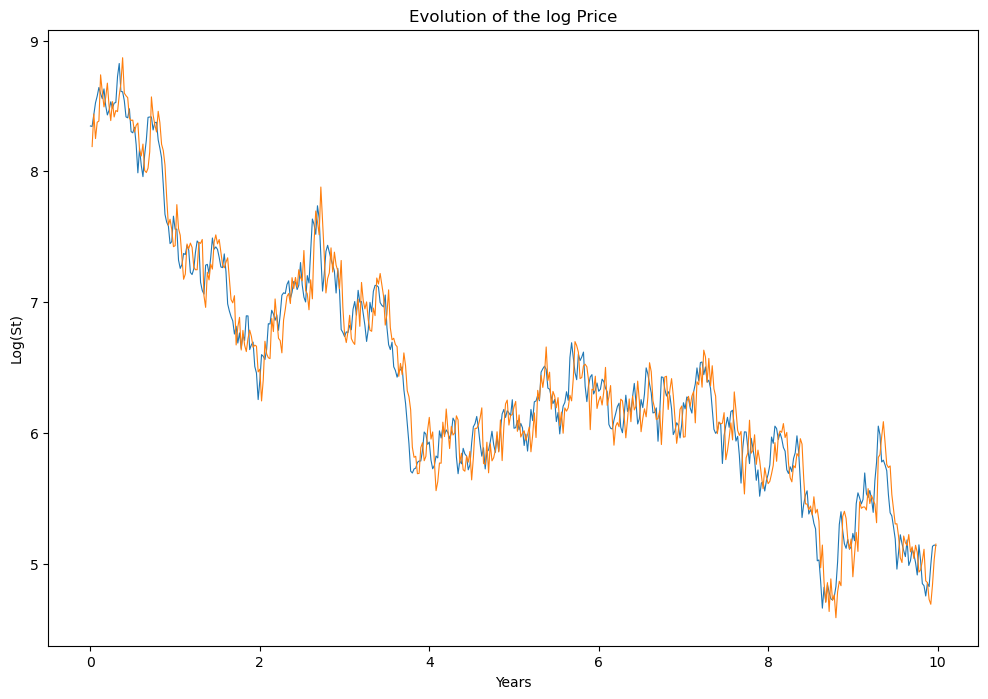

In [399]:
plt.figure(figsize=(12,8))
years = np.arange(obs.shape[-1]) * (T/N)
plt.plot(years, y[1:], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years[1:], obs[1:], label = 'Particle Filter log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.show()

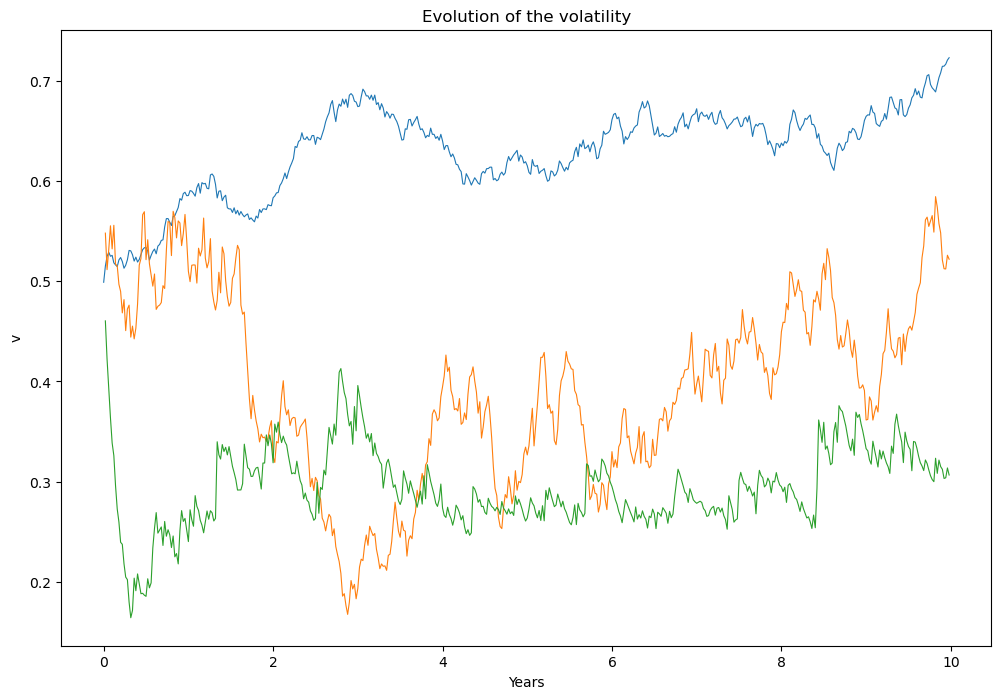

In [400]:
plt.figure(figsize=(12,8))
years = np.arange(v.shape[-1]) * (T/N)
plt.plot(years, v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v[1:], label = 'Particle Filter volatility', linewidth=0.8)
plt.plot(years[1:], v_bis[1:], label = 'Particle Filter volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.show()

## Results

In [442]:
params_result = pd.DataFrame({})
params_result['From'] = ['Simulation (true values)', 'Particle filter']
params_name = ['mu', 'kappa', 'theta', 'lambda_', 'rho', 'v_0']
p = np.sum(np.multiply(params_steps[-1], weights[np.newaxis, :]))
for i in range(len(params)):
    params_result[params_name[i]] = [params[i], params_states[i]]
params_result

NameError: name 'params_steps' is not defined

In [40]:
param_steps

array([[ 2.92564182e-02,  2.94331009e-02,  2.93127047e-02, ...,
         3.72436332e-02,  3.71791518e-02,  0.00000000e+00],
       [ 4.93463099e+00,  5.12412312e+00,  5.11840923e+00, ...,
         2.18721549e+00,  2.19947144e+00,  0.00000000e+00],
       [ 1.07463780e-01,  1.02464012e-01,  1.02625780e-01, ...,
         1.10462613e-01,  1.10223245e-01,  0.00000000e+00],
       [ 4.80548584e-01,  4.57091451e-01,  4.60376343e-01, ...,
         4.26279701e-01,  4.28044126e-01,  0.00000000e+00],
       [ 2.45323098e-01,  2.43846294e-01,  2.07967499e-01, ...,
        -5.98994154e-03, -1.31005455e-03,  0.00000000e+00]])

In [402]:
v

array([0.5       , 0.46261372, 0.43059633, 0.40157071, 0.37399703,
       0.34919478, 0.32689311, 0.30725385, 0.28947007, 0.27336974,
       0.26008628, 0.24801382, 0.23703871, 0.22689059, 0.21761509,
       0.20906969, 0.20198917, 0.19553517, 0.18965046, 0.18484434,
       0.1804487 , 0.17614416, 0.17220191, 0.16859024, 0.16575534,
       0.16273466, 0.15953123, 0.1565919 , 0.15392838, 0.15148813,
       0.1492519 , 0.14733696, 0.14557723, 0.14417113, 0.14331681,
       0.14264685, 0.141697  , 0.14081567, 0.14049246, 0.14019366,
       0.13991744, 0.13988305, 0.13985124, 0.13982182, 0.1400218 ,
       0.14020681, 0.14037796, 0.14084115, 0.14111662, 0.14166631,
       0.14217481, 0.14233908, 0.14195492, 0.14159704, 0.14130618,
       0.14064147, 0.14024461, 0.13987364, 0.13998597, 0.13968128,
       0.13955814, 0.13962401, 0.1392387 , 0.13941316, 0.13913551,
       0.13887531, 0.13948282, 0.14005143, 0.14058362, 0.14110309,
       0.14164417, 0.14215167, 0.14235283, 0.14239259, 0.14242

In [403]:
v_

array([0.5       , 0.50442627, 0.50726712, 0.50751649, 0.49843109,
       0.50153608, 0.50235869, 0.50067572, 0.50069524, 0.50122628,
       0.49611094, 0.49391301, 0.49215097, 0.48770434, 0.49003704,
       0.49087054, 0.49973788, 0.49119046, 0.49555343, 0.50488651,
       0.50588309, 0.51421116, 0.51148928, 0.51063548, 0.51360508,
       0.51032937, 0.50965486, 0.50239805, 0.49437016, 0.49770854,
       0.49443961, 0.49324374, 0.50232875, 0.50049905, 0.49819879,
       0.50019618, 0.50500771, 0.50703633, 0.50580102, 0.50733139,
       0.50344289, 0.49683921, 0.49557297, 0.4975981 , 0.50303655,
       0.50436111, 0.50491359, 0.50828845, 0.50950025, 0.50791348,
       0.51232557, 0.51586041, 0.52535231, 0.51832203, 0.51529148,
       0.51270632, 0.51024238, 0.50731399, 0.51025482, 0.5072769 ,
       0.51226095, 0.50800954, 0.51267649, 0.51563498, 0.52702273,
       0.53019869, 0.53490089, 0.53253117, 0.52818729, 0.53523579,
       0.53773266, 0.53081902, 0.53311701, 0.53848776, 0.53259

In [404]:
obs

array([8.31874225, 8.38470259, 8.53148155, 8.16041351, 8.1546507 ,
       8.26714699, 8.32701182, 8.36838372, 8.22044426, 8.3694967 ,
       8.24147786, 8.08662933, 8.02408535, 8.05666729, 7.99090644,
       7.82163162, 7.8625349 , 7.79898656, 7.96155259, 7.933712  ,
       8.25332469, 8.29613578, 8.31369884, 8.35786883, 8.34051567,
       8.41748018, 8.4214982 , 8.65973659, 8.40884424, 8.55052529,
       8.48733802, 8.42540187, 8.49784345, 8.34640261, 8.36562365,
       8.47575505, 8.60463351, 8.46783957, 8.46915263, 8.34109356,
       8.19213006, 8.22418681, 8.35109501, 8.34240833, 8.38800874,
       8.58278905, 8.61669267, 8.57178753, 8.55728904, 8.41794245,
       8.57854797, 8.48080111, 8.61780828, 8.80431706, 8.90408196,
       8.81249653, 8.79588357, 8.52573189, 8.5932988 , 8.82413651,
       8.53635106, 8.44222461, 8.44907179, 8.2164661 , 8.17208693,
       7.92141669, 7.92127847, 8.22367318, 8.13036627, 7.85859459,
       8.10804488, 7.92590837, 7.89792897, 7.91775438, 7.98129

In [405]:
y

array([8.31874225, 8.37567291, 8.20764269, 8.23791985, 8.33798656,
       8.26853789, 8.27074726, 8.22949626, 8.27906601, 8.25466712,
       8.09166731, 8.02563515, 7.95470746, 7.88975811, 7.87416452,
       7.78086984, 7.92267726, 7.94125513, 7.96881807, 8.17976866,
       8.26526655, 8.33734271, 8.27454667, 8.27681094, 8.40628072,
       8.48116132, 8.64548715, 8.54124448, 8.41413581, 8.42666579,
       8.48878778, 8.44655908, 8.39279144, 8.30172963, 8.43259535,
       8.56549047, 8.42347715, 8.45686983, 8.33783866, 8.27874179,
       8.27516072, 8.38512256, 8.37904256, 8.39805402, 8.55877418,
       8.62108286, 8.5781023 , 8.61293566, 8.51253463, 8.5980314 ,
       8.5492795 , 8.66323704, 8.80629672, 8.82842668, 8.7781039 ,
       8.68742978, 8.60758956, 8.5674962 , 8.6977732 , 8.52698418,
       8.45034525, 8.37984389, 8.28383024, 8.17943493, 7.93106685,
       7.9418188 , 8.06683915, 8.05541423, 8.02247409, 8.10046337,
       8.00299886, 7.93818723, 7.84955533, 7.97528611, 7.94221

test avec l'ami 

In [76]:
import numpy as np
import pandas as pd
from scipy.stats import norm

class ParticleFilter:
    
    def __init__(self, log_prices, n_particles, n_iterations):
        self.log_prices = log_prices
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.particles = None
        
    def _calculate_log_likelihood(self, y, x, theta):
        # Heston stochastic volatility model
        kappa, theta_v, sigma, rho, v0 = theta
        T = len(y)
        dt = 1 / 252
        log_likelihood = 0
        for t in range(1, T):
            z_v = np.random.normal(size=self.n_particles)
            z_s = np.random.normal(size=self.n_particles)
            v = np.maximum(v0 + kappa * (theta_v - np.maximum(x[:, t-1], 0)) * dt + sigma * np.sqrt(np.maximum(x[:, t-1], 0)) * np.sqrt(dt) * z_v, 0)
            #print('v',v)
            s = np.exp(np.log(np.exp(x[:, t-1]) + (theta_v - np.maximum(x[:, t-1], 0)) * v * dt + np.sqrt(np.maximum(x[:, t-1], 0)) * np.sqrt(dt) * rho * z_v + np.sqrt(np.maximum(v, 0)) * np.sqrt(dt) * np.sqrt(1 - rho**2) * z_s))
            #print('y(t)',y[t])
            #print('s', s)
            
            log_likelihood += norm.logpdf(y[t], s.mean(), s.std())
            #print('l',log_likelihood)
            x[:, t] = np.log(s)
            #print('x', x)
            
        # Check for nan values and replace with -inf
        if np.isnan(log_likelihood):
            log_likelihood = np.inf

        return log_likelihood
    
    def _resample(self, weights):
        u = np.random.uniform(size=self.n_particles)
        cumulative_weights = np.cumsum(weights)
        new_indices = np.zeros_like(u)
        i, j = 0, 0
        while i < self.n_particles and j < self.n_particles:
            if u[i] < cumulative_weights[j]:
                new_indices[i] = j
                i += 1
            else:
                j += 1
        return new_indices
    
    def fit(self):
        T = len(self.log_prices)
        self.particles = np.zeros((self.n_particles, T))
        weights = np.ones((self.n_particles,)) / self.n_particles
        theta = np.array([1, 1, 1, 0, np.log(self.log_prices[0])])
        x = np.ones((self.n_particles, T)) * np.log(self.log_prices[0])
        for i in tqdm(range(self.n_iterations)):
            #print(self.log_prices)
            #print(x)
            #print(theta)
            log_likelihood = self._calculate_log_likelihood(self.log_prices, x, theta)
            print('log_likelihood:',log_likelihood)
            weights *= np.exp(log_likelihood - np.max(log_likelihood))
            weights /= np.sum(weights)
            new_indices = [ int(x) for x in self._resample(weights) ]
            
            self.particles = self.particles[new_indices]
            x = x[new_indices]
            theta = theta + 0.1 * np.random.normal(size=(5,))
        return theta


In [77]:
# Create an instance of ParticleFilter
log_prices = y
n_particles = 1000
n_iterations = 100
pf = ParticleFilter(log_prices, n_particles, n_iterations)

# Fit the model and retrieve the estimated parameters
theta_hat = pf.fit()
print('Estimated parameters:', theta_hat)


  1%|█                                                                                                            | 1/100 [00:00<01:31,  1.08it/s]

log_likelihood: inf


  2%|██▏                                                                                                          | 2/100 [00:01<01:29,  1.10it/s]

log_likelihood: inf


  3%|███▎                                                                                                         | 3/100 [00:02<01:30,  1.07it/s]

log_likelihood: inf


  4%|████▎                                                                                                        | 4/100 [00:03<01:29,  1.08it/s]

log_likelihood: inf


  5%|█████▍                                                                                                       | 5/100 [00:04<01:27,  1.09it/s]

log_likelihood: inf


  6%|██████▌                                                                                                      | 6/100 [00:05<01:24,  1.11it/s]

log_likelihood: inf


  7%|███████▋                                                                                                     | 7/100 [00:06<01:24,  1.10it/s]

log_likelihood: inf


  8%|████████▋                                                                                                    | 8/100 [00:07<01:24,  1.09it/s]

log_likelihood: inf


  9%|█████████▊                                                                                                   | 9/100 [00:08<01:22,  1.11it/s]

log_likelihood: inf


 10%|██████████▊                                                                                                 | 10/100 [00:09<01:20,  1.12it/s]

log_likelihood: inf


 11%|███████████▉                                                                                                | 11/100 [00:09<01:19,  1.12it/s]

log_likelihood: inf


 12%|████████████▉                                                                                               | 12/100 [00:10<01:20,  1.09it/s]

log_likelihood: inf


 13%|██████████████                                                                                              | 13/100 [00:11<01:19,  1.10it/s]

log_likelihood: inf


 14%|███████████████                                                                                             | 14/100 [00:12<01:17,  1.11it/s]

log_likelihood: inf


 15%|████████████████▏                                                                                           | 15/100 [00:13<01:15,  1.12it/s]

log_likelihood: inf


 16%|█████████████████▎                                                                                          | 16/100 [00:14<01:15,  1.12it/s]

log_likelihood: inf


 17%|██████████████████▎                                                                                         | 17/100 [00:15<01:16,  1.08it/s]

log_likelihood: inf


 18%|███████████████████▍                                                                                        | 18/100 [00:16<01:14,  1.10it/s]

log_likelihood: inf


 19%|████████████████████▌                                                                                       | 19/100 [00:17<01:12,  1.11it/s]

log_likelihood: inf


 20%|█████████████████████▌                                                                                      | 20/100 [00:18<01:12,  1.10it/s]

log_likelihood: inf


 21%|██████████████████████▋                                                                                     | 21/100 [00:19<01:14,  1.06it/s]

log_likelihood: inf


 22%|███████████████████████▊                                                                                    | 22/100 [00:20<01:16,  1.02it/s]

log_likelihood: inf


 23%|████████████████████████▊                                                                                   | 23/100 [00:21<01:14,  1.03it/s]

log_likelihood: inf


 24%|█████████████████████████▉                                                                                  | 24/100 [00:22<01:13,  1.04it/s]

log_likelihood: inf


 25%|███████████████████████████                                                                                 | 25/100 [00:23<01:13,  1.03it/s]

log_likelihood: inf


 26%|████████████████████████████                                                                                | 26/100 [00:23<01:09,  1.07it/s]

log_likelihood: inf


 27%|█████████████████████████████▏                                                                              | 27/100 [00:24<01:06,  1.09it/s]

log_likelihood: inf


 28%|██████████████████████████████▏                                                                             | 28/100 [00:25<01:04,  1.11it/s]

log_likelihood: inf


 29%|███████████████████████████████▎                                                                            | 29/100 [00:26<01:05,  1.09it/s]

log_likelihood: inf


 30%|████████████████████████████████▍                                                                           | 30/100 [00:27<01:03,  1.10it/s]

log_likelihood: inf


 31%|█████████████████████████████████▍                                                                          | 31/100 [00:28<01:05,  1.05it/s]

log_likelihood: inf


 32%|██████████████████████████████████▌                                                                         | 32/100 [00:29<01:04,  1.05it/s]

log_likelihood: inf


 33%|███████████████████████████████████▋                                                                        | 33/100 [00:30<01:04,  1.05it/s]

log_likelihood: inf


 34%|████████████████████████████████████▋                                                                       | 34/100 [00:31<01:05,  1.01it/s]

log_likelihood: inf


 35%|█████████████████████████████████████▊                                                                      | 35/100 [00:32<01:03,  1.03it/s]

log_likelihood: inf


 36%|██████████████████████████████████████▉                                                                     | 36/100 [00:33<00:59,  1.07it/s]

log_likelihood: inf


 37%|███████████████████████████████████████▉                                                                    | 37/100 [00:34<00:59,  1.06it/s]

log_likelihood: inf


 38%|█████████████████████████████████████████                                                                   | 38/100 [00:35<00:59,  1.05it/s]

log_likelihood: inf


 39%|██████████████████████████████████████████                                                                  | 39/100 [00:36<00:59,  1.03it/s]

log_likelihood: inf


 40%|███████████████████████████████████████████▏                                                                | 40/100 [00:37<00:57,  1.04it/s]

log_likelihood: inf


 41%|████████████████████████████████████████████▎                                                               | 41/100 [00:38<00:57,  1.02it/s]

log_likelihood: inf


 42%|█████████████████████████████████████████████▎                                                              | 42/100 [00:39<00:55,  1.05it/s]

log_likelihood: inf


 43%|██████████████████████████████████████████████▍                                                             | 43/100 [00:40<00:52,  1.08it/s]

log_likelihood: inf


 44%|███████████████████████████████████████████████▌                                                            | 44/100 [00:41<00:52,  1.06it/s]

log_likelihood: inf


 45%|████████████████████████████████████████████████▌                                                           | 45/100 [00:42<00:52,  1.04it/s]

log_likelihood: inf


 46%|█████████████████████████████████████████████████▋                                                          | 46/100 [00:42<00:50,  1.06it/s]

log_likelihood: inf


 47%|██████████████████████████████████████████████████▊                                                         | 47/100 [00:43<00:49,  1.06it/s]

log_likelihood: inf


 48%|███████████████████████████████████████████████████▊                                                        | 48/100 [00:44<00:49,  1.05it/s]

log_likelihood: inf


 49%|████████████████████████████████████████████████████▉                                                       | 49/100 [00:45<00:47,  1.06it/s]

log_likelihood: inf


 50%|██████████████████████████████████████████████████████                                                      | 50/100 [00:46<00:48,  1.04it/s]

log_likelihood: inf


 51%|███████████████████████████████████████████████████████                                                     | 51/100 [00:47<00:47,  1.04it/s]

log_likelihood: inf


 52%|████████████████████████████████████████████████████████▏                                                   | 52/100 [00:48<00:45,  1.06it/s]

log_likelihood: inf


 53%|█████████████████████████████████████████████████████████▏                                                  | 53/100 [00:49<00:43,  1.08it/s]

log_likelihood: inf


 54%|██████████████████████████████████████████████████████████▎                                                 | 54/100 [00:50<00:42,  1.07it/s]

log_likelihood: inf


 55%|███████████████████████████████████████████████████████████▍                                                | 55/100 [00:51<00:42,  1.06it/s]

log_likelihood: inf


 56%|████████████████████████████████████████████████████████████▍                                               | 56/100 [00:52<00:41,  1.06it/s]

log_likelihood: inf


 57%|█████████████████████████████████████████████████████████████▌                                              | 57/100 [00:53<00:41,  1.04it/s]

log_likelihood: inf


 58%|██████████████████████████████████████████████████████████████▋                                             | 58/100 [00:54<00:41,  1.02it/s]

log_likelihood: inf


 59%|███████████████████████████████████████████████████████████████▋                                            | 59/100 [00:55<00:40,  1.01it/s]

log_likelihood: inf


 60%|████████████████████████████████████████████████████████████████▊                                           | 60/100 [00:56<00:38,  1.04it/s]

log_likelihood: inf


 61%|█████████████████████████████████████████████████████████████████▉                                          | 61/100 [00:57<00:37,  1.03it/s]

log_likelihood: inf


 62%|██████████████████████████████████████████████████████████████████▉                                         | 62/100 [00:58<00:37,  1.01it/s]

log_likelihood: inf


 63%|████████████████████████████████████████████████████████████████████                                        | 63/100 [00:59<00:36,  1.02it/s]

log_likelihood: inf


 64%|█████████████████████████████████████████████████████████████████████                                       | 64/100 [01:00<00:37,  1.03s/it]

log_likelihood: -4575.865715382477


 65%|██████████████████████████████████████████████████████████████████████▏                                     | 65/100 [01:01<00:36,  1.05s/it]

log_likelihood: -4689.422910128807


 66%|███████████████████████████████████████████████████████████████████████▎                                    | 66/100 [01:02<00:34,  1.03s/it]

log_likelihood: inf


 67%|████████████████████████████████████████████████████████████████████████▎                                   | 67/100 [01:03<00:32,  1.03it/s]

log_likelihood: inf


 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 68/100 [01:04<00:30,  1.04it/s]

log_likelihood: inf


 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 69/100 [01:05<00:29,  1.04it/s]

log_likelihood: inf


 70%|███████████████████████████████████████████████████████████████████████████▌                                | 70/100 [01:06<00:29,  1.03it/s]

log_likelihood: inf


 71%|████████████████████████████████████████████████████████████████████████████▋                               | 71/100 [01:07<00:28,  1.01it/s]

log_likelihood: inf


 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 72/100 [01:08<00:28,  1.03s/it]

log_likelihood: inf


 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 73/100 [01:09<00:27,  1.01s/it]

log_likelihood: inf


 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 74/100 [01:10<00:25,  1.03it/s]

log_likelihood: inf


 75%|█████████████████████████████████████████████████████████████████████████████████                           | 75/100 [01:11<00:23,  1.08it/s]

log_likelihood: inf


 76%|██████████████████████████████████████████████████████████████████████████████████                          | 76/100 [01:11<00:21,  1.11it/s]

log_likelihood: inf


 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 77/100 [01:12<00:20,  1.12it/s]

log_likelihood: inf


 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 78/100 [01:13<00:19,  1.14it/s]

log_likelihood: inf


 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 79/100 [01:14<00:19,  1.09it/s]

log_likelihood: -8437.036423794623


 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 80/100 [01:15<00:18,  1.11it/s]

log_likelihood: inf


 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 81/100 [01:16<00:17,  1.07it/s]

log_likelihood: -5111.937446601725


 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 82/100 [01:17<00:17,  1.04it/s]

log_likelihood: -6345.944357984578


 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 83/100 [01:18<00:16,  1.03it/s]

log_likelihood: -9892.84649744328


 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 84/100 [01:19<00:15,  1.06it/s]

log_likelihood: inf


 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 85/100 [01:20<00:14,  1.04it/s]

log_likelihood: -4874.310165999899


 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 86/100 [01:21<00:13,  1.01it/s]

log_likelihood: -4647.794505041991


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 87/100 [01:22<00:13,  1.04s/it]

log_likelihood: -4484.451222178453


 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 88/100 [01:23<00:13,  1.10s/it]

log_likelihood: -4497.26709744518


 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 89/100 [01:25<00:12,  1.15s/it]

log_likelihood: -4496.450930498823


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 90/100 [01:26<00:10,  1.08s/it]

log_likelihood: inf


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 91/100 [01:27<00:09,  1.06s/it]

log_likelihood: inf


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 92/100 [01:27<00:07,  1.00it/s]

log_likelihood: inf


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 93/100 [01:28<00:06,  1.07it/s]

log_likelihood: inf


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 94/100 [01:29<00:05,  1.10it/s]

log_likelihood: inf


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 95/100 [01:30<00:04,  1.01it/s]

log_likelihood: -4423.048431992581


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 96/100 [01:31<00:04,  1.01s/it]

log_likelihood: -4770.446852179923


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97/100 [01:33<00:03,  1.11s/it]

log_likelihood: -5156.675451336763


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97/100 [01:33<00:02,  1.03it/s]


KeyboardInterrupt: 

In [78]:
s = np.array([ np.nan ,3.64642843 ,3.27488982])
s.max()

nan